In [34]:
# Import necessary libraries
import jax.numpy as jnp
from jax import random, grad, jit, lax, jacrev
from jax.scipy.linalg import inv, svd, eigh, det
from jax.numpy.linalg import norm
from tqdm import tqdm
from sklearn.datasets import make_spd_matrix
from jax_models import Lorenz96
from jax_models import visualize_observations, Lorenz96, generate_true_states, generate_gc_localization_matrix
from jax_filters import ensrf_steps, kalman_filter_process
import jax
import matplotlib.pyplot as plt
#from jax_vi import KL_gaussian, log_likelihood
from jax.tree_util import Partial



# Parameters
F = 8.0
dt = 0.05
num_steps = 250  # Number of time steps

J0 = 0
n = 40   # Number of state variables
Q = 0.2 * jnp.eye(n)  # Process noise covariance
R_matrix = 0.5 * jnp.eye(n)
R = jnp.array(R_matrix)  # Observation noise covariance
inv_R = inv(R)
H = jnp.eye(n)  # Observation matrix


N = 10
n_ensemble = 10
observation_interval = 1
initial_state = random.normal(random.PRNGKey(0), (n,))  # Initial state
m0 = initial_state
C0 = Q

l96_model = Lorenz96(dt = dt, F = F)
state_transition_function = l96_model.step
l96_step = Partial(state_transition_function)
jacobian_function = jacrev(l96_step, argnums=0)
jac_func = Partial(jacobian_function)
# Generate true states and observations using the Lorenz '96 model
key = random.PRNGKey(0)
observations, true_states = generate_true_states(key, num_steps, n, initial_state, H, Q, R, l96_step, observation_interval)

In [35]:
radius = 10
localization_matrix = generate_gc_localization_matrix(n, radius)
ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T
inflation = 1
e, c = ensrf_steps(l96_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation, key)


In [36]:
# plt.pcolormesh(c[-1])
# plt.colorbar()

In [37]:
from jax_vi import KL_gaussian, log_likelihood, KL_sum

def var_cost(inflation, ensemble_init, observations, H, Q, R, localization_matrix, key, num_steps, J0):
   
    states, covariances = ensrf_steps(l96_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation, key)
    ensemble_mean = jnp.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    key, *subkeys = random.split(key, num=N+1)
    kl_sum = KL_sum(ensemble_mean, covariances, n, l96_step, Q, key, N)

    def inner_map(subkey):
        return log_likelihood(random.multivariate_normal(subkey, ensemble_mean, covariances), observations, H, R, num_steps, J0)  # Sometimes the covariances are negative definite. Fix
    cost = kl_sum - jnp.nanmean(jax.lax.map(inner_map, jnp.vstack(subkeys)))
    
    return cost

In [38]:
var_cost(inflation, ensemble_init, observations, H, Q, R, localization_matrix, key, num_steps, J0)

Array(107320.75, dtype=float32)

In [39]:
m, C, K = kalman_filter_process(l96_step, jac_func, m0, C0, observations, H, Q, R)


In [40]:
from IPython.display import clear_output
from jax import grad
from tqdm.notebook import tqdm
import jax.numpy as jnp
from jax import random
import properscoring


# Modification: Use grad to compute the gradient with respect to the inflation parameter
var_cost_grad = grad(var_cost, argnums=0)

inflation_opt = 1.3 # Example starting value for inflation
alpha = 1e-6  # Learning rate
key = random.PRNGKey(0)  # Random key
N = 10  # Number of MC samples
m0 = initial_state
C0 = Q  # Initial covariance, assuming Q is your process noise covariance
localization_matrix = generate_gc_localization_matrix(n, radius)# jnp.ones((n, n)) # 
ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T

crpss = []
rmses=[]
inflations = []
errs = []


# from jax import config
# config.update("jax_debug_nans", True)

for i in tqdm(range(50)):
    key, subkey = random.split(key)
        
    # Gradient descent step for inflation parameter
    grad_inflation = var_cost_grad(inflation_opt, ensemble_init, observations, H, Q, R, localization_matrix, subkey, num_steps, J0)
    inflation_opt -= alpha * grad_inflation  # Update inflation parameter
    
    inflations.append(inflation_opt)

    states, covariances = ensrf_steps(l96_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation_opt, key)
    ensemble_mean = jnp.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    rmse = jnp.sqrt(jnp.mean((ensemble_mean - true_states)**2))
    rmses.append(rmse)
    crps = properscoring.crps_ensemble(m, states).mean(axis=1).mean()
    crpss.append(crps)
    #clear_output(wait=True)
    


  0%|          | 0/50 [00:00<?, ?it/s]

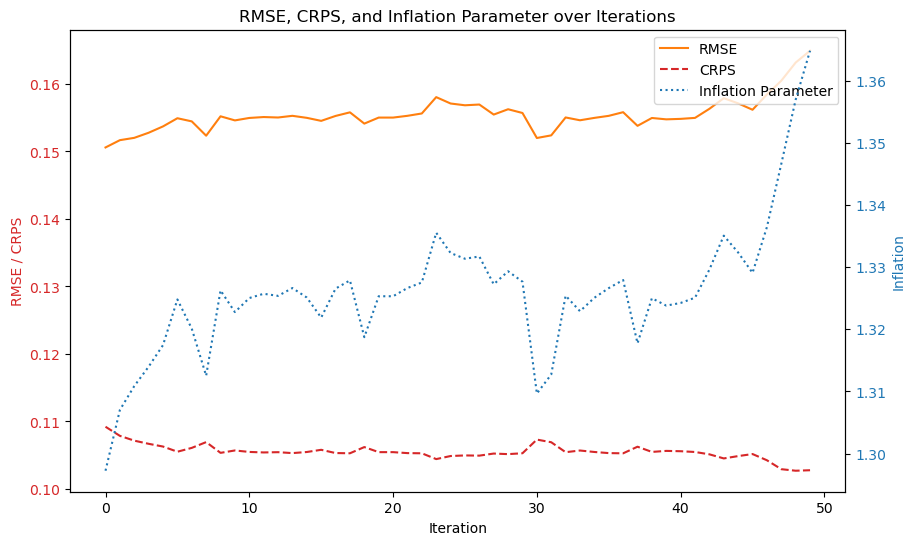

In [41]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting the RMSE and CRPS on the primary y-axis
color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('RMSE / CRPS', color=color)
ln1 = ax1.plot(rmses, label='RMSE', color='tab:orange', linestyle='-')
ln2 = ax1.plot(crpss, label='CRPS', color='tab:red', linestyle='--')
ax1.tick_params(axis='y', labelcolor=color)

# Create a twin y-axis for the inflation parameter
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Inflation', color=color)
ln3 = ax2.plot(inflations, label='Inflation Parameter', color=color, linestyle=':')
ax2.tick_params(axis='y', labelcolor=color)

# Combine legends from both axes
lns = ln1 + ln2 + ln3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper right')

plt.title('RMSE, CRPS, and Inflation Parameter over Iterations')
plt.show()
